# Compute Betti curves out of 2D images

Given a 2D image of pavement cells, we can filter it by cell area and compute its Betti curves to topologically describe the shape of the pattern. Rieck et al (2020) calls them indicator functions.

Betti curves may not capture as much information as persistence diagrams, but they offer important advantages
- They are quick to implement and compute, since they look only at number of connected components and holes.
- The output is a vector, so we have access to all the traditional statistical tools
    - Compute the mean curve
    - Confidence intervals via bootstraping
    - 2-way goodness of fit (GoF) test available on whether two curves come from the same distribution
    
These tools are mostly discussed in Rieck et al (2020).

Relevant literature:

- O. Bobrowski, M. Kahle (2018) Topology of random geometric complexes: a survey. [DOI: 10.1007/s41468-017-0010-0](https://doi.org/10.1007/s41468-017-0010-0)
- MJ. Haus, M. Li, DH. Chitwood, TW Jacobs (2018) Long-Distance and Trans-Generational Stomatal Patterning by CO2 Across Arabidopsis Organs. [DOI: 10.3389/fpls.2018.01714](https://doi.org/10.3389/fpls.2018.01714)
- B. Rieck, F. Sadlo, H. Leitte (2020) Topological Machine Learning with Persistence Indicator Functions. [DOI: 10.1007/978-3-030-43036-8_6](https://doi.org/10.1007/978-3-030-43036-8_6)

## The script

- Load necessary packages. 

Just the basics are necessary. `os` and `glob` come by default. `Numpy`, `scipy`, `matplotlib`, and `pandas` are pretty standard.

I like `tifffile` to load TIFF images, but other options may be available. `skimage` might be convenient to do things in 3D.


In [76]:
import glob
import os
import json
import tifffile as tf
import numpy as np
import pandas as pd
from scipy import ndimage, stats, spatial

import matplotlib.pyplot as plt

bordermask = ndimage.generate_binary_structure(2,1).astype(int)
bordermask[1,1] = -bordermask.sum() + 1
bordermask

array([[ 0,  1,  0],
       [ 1, -4,  1],
       [ 0,  1,  0]])

## Load the data from a source directory `src`

- All the data files are insidea a `data` directory
- Each tissue/variant is its own folder
- We do `glob.glob` to get automatically the name of all the folders
- For example, the 3rd source folder `sidx = 3` corresponds to `../results/sepal/`

### Define a destination directory `dst`

- For consistency, the `results` folder should have the same structure as the `data` one.
- If the folder, say `../results/sepal/` is not existent, we can make it automatically

In [2]:
filesrcs = sorted(glob.glob(os.pardir + os.sep + 'data' + os.sep + '*' + os.sep))
filesrcs

['../data/leaf_25d_WT2/',
 '../data/leaf_25d_WT4/',
 '../data/leaf_25d_WT4_random/',
 '../data/sepal/',
 '../data/sepal_random/']

In [3]:
sidx = 1

src = filesrcs[sidx]
dst = os.pardir + os.sep + 'results' + os.sep + os.path.dirname(src).split(os.sep)[-1] + os.sep
print(dst)
if not os.path.isdir(dst):
    os.makedirs(dst)

../results/leaf_25d_WT4/


## Load the data

- Make a list of all the `.tiff` and `.tif` files inside the source folder.
- This is convenient for the random folders that contain several images

In [4]:
tifffiles = sorted(glob.glob(src + '*.tif*'))
print(tifffiles)

tidx = 0
tifffile = tifffiles[tidx]
_,filename = os.path.split(tifffile)
bname, _ = os.path.splitext(filename)
print(tidx, filename, bname, sep='\t')

['../data/leaf_25d_WT4/segmentation.tiff']
0	segmentation.tiff	segmentation


In [5]:
img = tf.imread(tifffile)
print(filename, img.min(), img.max(), img.shape, img.dtype, sep='\t')
coms = np.asarray(ndimage.center_of_mass(img, img, range(img.min(), img.max()+1)))
css = ndimage.find_objects(img)

segmentation.tiff	1	638	(2886, 3013)	uint16


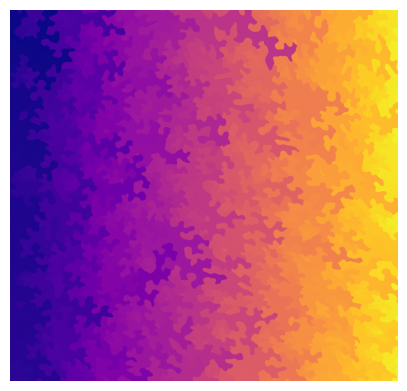

In [51]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(img, cmap='plasma')
ax.axis('off');

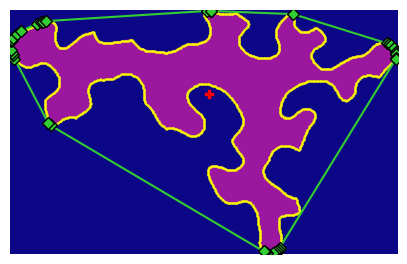

In [57]:
idx = 314

pad = 2
xy1 = np.array([0.5,-0.5]).reshape(-1,1)
xy2 = np.array([-0.5,0.5]).reshape(-1,1)

s_ = (np.s_[max(0, css[idx][0].start - pad) : min(img.shape[0], css[idx][0].stop + pad)] , 
      np.s_[max(0, css[idx][1].start - pad) : min(img.shape[1], css[idx][1].stop + pad)])
extent = (s_[1].start, s_[1].stop, s_[0].stop, s_[0].start)
cell = img[s_] == idx + 1

nzborder = ndimage.convolve(cell.astype(int), bordermask, mode='constant', cval=0)

label, n = ndimage.label(nzborder < 0, ndimage.generate_binary_structure(2,1))
hist, _ = np.histogram(label, range(1, n+2))
perimeter = np.sum(hist - 1) + n*np.sqrt(2)

border = np.asarray(np.nonzero(nzborder < 0)).astype(float)
chborder = np.hstack((border + 0.5, border - 0.5, border + xy1, border + xy2))

convexhull = spatial.ConvexHull(np.flip(chborder).T)
hull = convexhull.points[convexhull.vertices]
hull = np.vstack( (hull, hull[0])).T

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(cell, cmap='plasma', origin='upper', vmin=0, vmax=3)
ax.scatter(coms[idx,1] - extent[0], coms[idx, 0] - extent[3], c='r', marker='P', s=30)
ax.scatter(border[1], border[0] , c='yellow', marker='.', s=1)
ax.plot(hull[0], hull[1] , c='limegreen', marker='D', mec='k')
ax.axis('off');

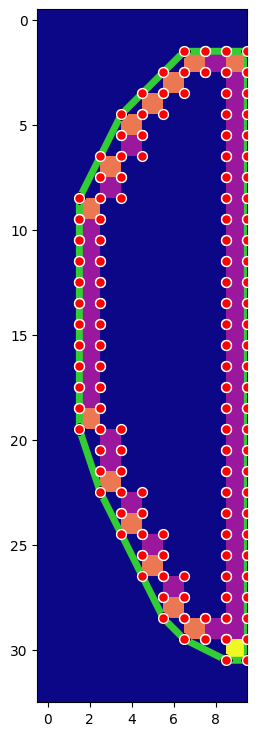

In [56]:
fig, ax = plt.subplots(1,1, figsize=(9,9))
ax.imshow(label, cmap='plasma', origin='upper', vmin=0)
ax.imshow(nzborder, cmap='plasma_r', origin='upper', vmax=0)
#ax.imshow(nzborder, cmap='plasma', origin='upper', vmin=0)
ax.scatter(chborder[1], chborder[0], c='red', marker='o', s=50, ec='w', zorder=5)
ax.plot(hull[0], hull[1], c='limegreen', marker='D', mec='k', lw=5);

In [50]:
datafile = src + bname + '_metadata.csv'

if not os.path.isfile(datafile):
    pad = 2
    xy1 = np.array([0.5,-0.5]).reshape(-1,1)
    xy2 = np.array([-0.5,0.5]).reshape(-1,1)
    
    columns = ['centerX', 'centerY', 'perimeter', 'area', 'ch_perimeter', 'ch_area', 'pconvexity', 'aconvexity']
    data = pd.DataFrame(0., index=range(1, len(css)+1), columns=columns)
    
    for idx in range(len(data)):
        
        s_ = (np.s_[max(0, css[idx][0].start - pad) : min(img.shape[0], css[idx][0].stop + pad)] , 
              np.s_[max(0, css[idx][1].start - pad) : min(img.shape[1], css[idx][1].stop + pad)])
        cell = img[s_] == idx + 1
        area = cell.sum()
        
        nzborder = ndimage.convolve(cell.astype(int), bordermask, mode='constant', cval=0) < 0
        
        label, n = ndimage.label(nzborder, ndimage.generate_binary_structure(2,1))
        hist, _ = np.histogram(label, range(1, n+2))
        perimeter = np.sum(hist - 1) + n*np.sqrt(2)
    
        border = np.asarray(np.nonzero(nzborder)).astype(float)
        chborder = np.hstack((border + 0.5, border - 0.5, border + xy1, border + xy2))
        convexhull = spatial.ConvexHull(np.flip(chborder).T)
        
        data.loc[idx + 1] = [coms[idx,1], coms[idx,0], perimeter, area, 
                             convexhull.area, convexhull.volume, convexhull.area/perimeter, area/convexhull.volume] 
    data = data.astype({'area':int})
    data.to_csv(datafile, index=True, index_label='Label')

data = pd.read_csv(datafile).set_index('Label')
print(data.shape)
data.head()

(638, 8)


,centerX,centerY,perimeter,area,ch_perimeter,ch_area,pconvexity,aconvexity
Label,,,,,,,,
1,61.373869,58.106198,580.546248,11940,470.552743,15041.0,0.810534,0.793830
2,18.980871,142.452079,408.048773,5123,366.442229,6587.5,0.898035,0.777685
3,232.277407,211.739969,2325.228714,50817,1257.422040,104085.0,0.540773,0.488226
4,26.463696,290.688065,260.894444,3209,236.955745,3862.5,0.908244,0.830809
5,250.284159,411.948938,2834.414572,64960,1388.076410,122924.5,0.489722,0.528454


### Load the cell areas and other measurables

- Make sure the file **ends** with `_data_membrane.csv`

In [74]:
datafile = src + bname + '_neighbors.json'

if not os.path.isfile(datafile):
    neighbors = dict()
    pad = 2
    for idx in range(len(css)):
        s_ = (np.s_[max(0, css[idx][0].start - pad) : min(img.shape[0], css[idx][0].stop + pad)] , 
              np.s_[max(0, css[idx][1].start - pad) : min(img.shape[1], css[idx][1].stop + pad)])
        cell = img[s_] == idx + 1
        
        nzborder = ndimage.convolve(cell.astype(int), bordermask, mode='constant', cval=0) > 0
        neighbors[idx + 1] = np.unique(img[s_][nzborder]).tolist()
    with open(datafile, 'w') as f:
        json.dump(neighbors, f, indent=1, separators=(',', ':'))

with open(datafile, "r") as f:
    neigbors = json.load(f)

Consider the interval `(area_min, area_max)` and split it into `TT = 32` equispaced thresholds.

We will then keep track of the number of connected components and holes at each of these thresholds.

In [54]:
TT = 32
filterval = 'Geometry/Area'
#filterval = 'Lobeyness/Circularity'
arearange = np.linspace(np.min(data[filterval]), np.max(data[filterval]), TT)
digis = np.digitize(data[filterval].values, arearange)

arange = np.zeros(len(arearange)+1)
arange[:-1] = arearange
arange[-1] = arange[-2]
arange[np.linspace(0,TT,TT//4+1).astype(int)]

print(len(np.unique(digis)))
print(digis.max())
print(digis.min())

22
32
1


Make a copy of the TIFF and relabel it based on the interval from above.

In [55]:
limg = img.copy()
for i in range(len(data)):
    limg[ limg == data['Label'].iloc[i] ] = digis[i]
limg[limg == 0] = 1

print(filename, limg.min(), limg.max(), limg.shape, sep='\t')

segmentation.tiff	1	32	(2886, 3013)


Make sure we can visualize the TIFF

../results/leaf_25d_WT4/pavement_geometry_area_segmentation


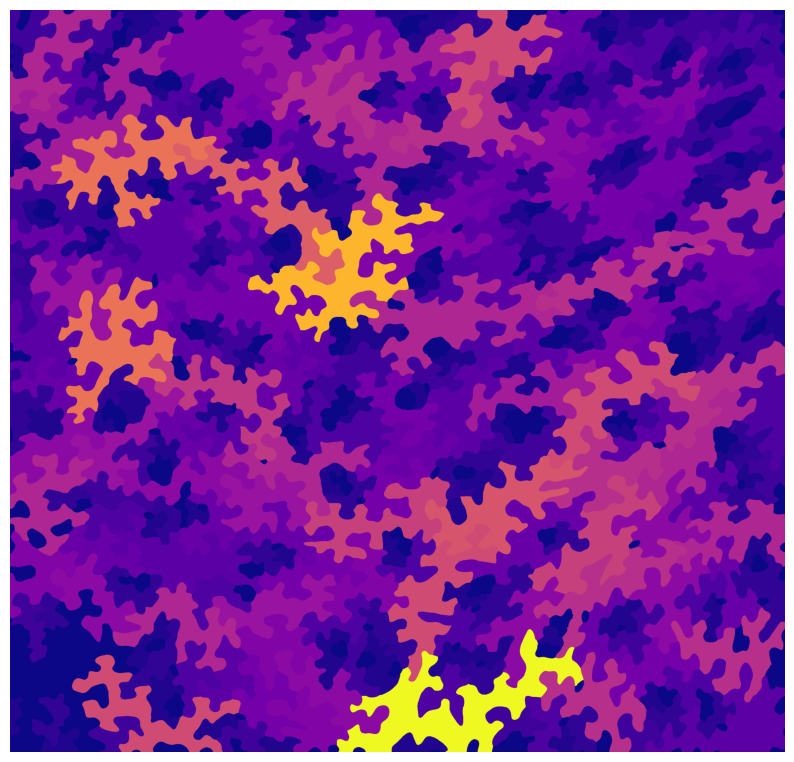

In [56]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(limg, origin='lower', cmap='plasma');
ax.axis('off');

filename = dst + 'pavement_' + filterval.replace('/','_').lower() + '_' + bname
print(filename)
plt.savefig(filename+'.jpg', format='jpg', dpi=300, bbox_inches='tight', pil_kwargs={'optimize':True})

In [12]:
# Function to count the number of connected components and holes in a 2D image
#
# INPUT:
#     `img` : a 2D numpy array of an image
#     `structure`: connectivity structure to compute both connected components and holes. 
#                  It can be either 4N or 8N
#                  See https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.generate_binary_structure.html
#
# OUTPUT:
#     `betti0`: Number of connected components
#     `betti1`: Number of holes

def betti0_betti1(cimg, structure):
    
    # The image is binarized
    img = cimg.copy()
    img[img > 0] = 1 
    
    # Count the number of connected components
    _ , betti0 = ndimage.label(img, structure)
    
    # Next fill in all the holes.
    # Then compared the original image to the one filled
    # The difference are the holes
    # Count the connected components of the difference ie. count the individual holes
    fimg = img.copy()
    fimg = ndimage.binary_fill_holes(fimg, struc)
    fimg = fimg - img
        
    _ , betti1 = ndimage.label(fimg, structure)
    
    return [betti0,betti1]

There are two basic ways to filter the image:
- **Bottom up**: We start with nothing, then we add the smallest cells, then the small cells, next medium-sized cells, and so on.
    - We see a bunch of connected components at first
    - These components start to merge and their number decreases
    - Holes appear at some point
    - These holes are filled in by the end

- **Top bottom**: We start with nothing, then we add the largest cells, then the large cells, next medium-sized cells, and so on.
    - We start with few connected components
    - These start to increase, and later merge
    - Tiny holes start to appear and their number increases as time goes on
    
For either case, we use 8N-connectivity. That is, each pixel has 8 neighbors. The alternative is 4N, where pixels are only neighbors if they share a full side. See [https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.generate_binary_structure.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.generate_binary_structure.html)

# TOP BOTTOM

In [14]:
# TOP BOTTOM

struc = ndimage.generate_binary_structure(img.ndim, 2)
betti = np.zeros((TT+1,img.ndim), dtype=np.uint)

fimg = TT + 1 - limg.copy()

for i in range(len(betti)):    
    fimg[fimg > TT - i] = 0
    betti[-i-1] = betti0_betti1(fimg, struc)
    print(i, -i-1, len(betti) -i-1, betti[-i-1], sep='\t')
    
filename = dst + 'betti_' + bname + '_top_down.csv'
pd.DataFrame(betti, columns=['betti0', 'betti1']).to_csv(filename, index=False)

0	-1	32	[1 0]
1	-2	31	[  2 140]
2	-3	30	[20  8]
3	-4	29	[13  6]
4	-5	28	[13  2]
5	-6	27	[10  2]
6	-7	26	[11  2]
7	-8	25	[11  1]
8	-9	24	[10  1]
9	-10	23	[9 0]
10	-11	22	[9 0]
11	-12	21	[6 0]
12	-13	20	[6 0]
13	-14	19	[6 0]
14	-15	18	[6 0]
15	-16	17	[5 0]
16	-17	16	[4 0]
17	-18	15	[4 0]
18	-19	14	[4 0]
19	-20	13	[4 0]
20	-21	12	[3 0]
21	-22	11	[2 0]
22	-23	10	[2 0]
23	-24	9	[2 0]
24	-25	8	[2 0]
25	-26	7	[2 0]
26	-27	6	[2 0]
27	-28	5	[2 0]
28	-29	4	[2 0]
29	-30	3	[2 0]
30	-31	2	[2 0]
31	-32	1	[1 0]
32	-33	0	[0 0]


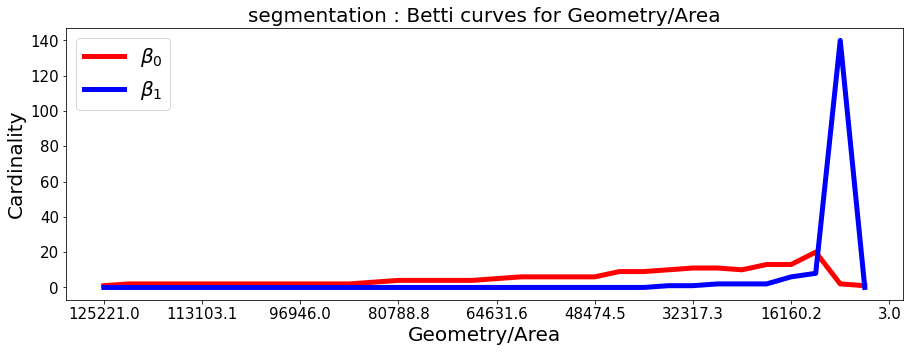

In [15]:
fs=20

fig, ax = plt.subplots(1,1,figsize=(15,5))

ax.plot(betti[1:,0], c='r', lw=5, label='$\\beta_0$')
ax.plot(betti[1:,1], c='b', lw=5, label='$\\beta_1$')
ax.legend(fontsize=fs)

ax.set_ylabel('Cardinality', fontsize=fs)
ax.set_xlabel(filterval, fontsize=fs)
ax.set_xticks(np.linspace(0,TT,TT//4+1))
ax.set_xticklabels(np.round(arange[np.linspace(0,TT,TT//4+1).astype(int)],1)[::-1]);
ax.set_title(bname + ' : Betti curves for ' + filterval, fontsize=fs);
ax.tick_params(labelsize=fs-5)

filename = dst + 'betticurve_top_down_' + bname + '_' + filterval.replace('/','_').lower() + '.jpg'
plt.savefig(filename, format='jpg', dpi=100, bbox_inches='tight', pil_kwargs={'optimize':True});

# BOTTOM UP

In [54]:
struc = ndimage.generate_binary_structure(img.ndim, 2)
betti = np.zeros((TT+1,img.ndim), dtype=np.uint)

fimg = limg.copy()

for i in range(len(betti)):
    fimg[fimg > TT - i] = 0
    betti[-i-1] = betti0_betti1(fimg, struc)
    print(i, -i-1, len(betti) -i-1, betti[-i-1], sep='\t')
    
filename = dst + 'betti_' + bname + '_bottom_up.csv'
pd.DataFrame(betti, columns=['betti0', 'betti1']).to_csv(filename, index=False)

0	-1	32	[1 0]
1	-2	31	[1 1]
2	-3	30	[1 2]
3	-4	29	[1 2]
4	-5	28	[1 2]
5	-6	27	[1 2]
6	-7	26	[1 2]
7	-8	25	[1 2]
8	-9	24	[1 2]
9	-10	23	[1 2]
10	-11	22	[1 2]
11	-12	21	[1 2]
12	-13	20	[1 2]
13	-14	19	[1 3]
14	-15	18	[1 3]
15	-16	17	[1 3]
16	-17	16	[1 3]
17	-18	15	[1 4]
18	-19	14	[1 5]
19	-20	13	[1 5]
20	-21	12	[1 5]
21	-22	11	[1 5]
22	-23	10	[1 6]
23	-24	9	[1 6]
24	-25	8	[2 7]
25	-26	7	[2 8]
26	-27	6	[5 8]
27	-28	5	[5 7]
28	-29	4	[ 5 10]
29	-30	3	[10 10]
30	-31	2	[16 11]
31	-32	1	[178   1]
32	-33	0	[0 0]


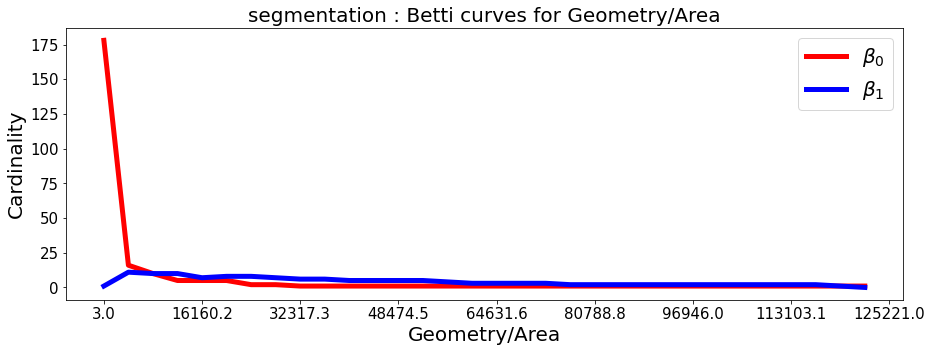

In [56]:
fs=20

fig, ax = plt.subplots(1,1,figsize=(15,5))

ax.plot(betti[1:,0], c='r', lw=5, label='$\\beta_0$')
ax.plot(betti[1:,1], c='b', lw=5, label='$\\beta_1$')
ax.legend(fontsize=fs)

ax.set_ylabel('Cardinality', fontsize=fs)
ax.set_xlabel(filterval, fontsize=fs)
ax.set_xticks(np.linspace(0,TT,TT//4+1))
ax.set_xticklabels(np.round(arange[np.linspace(0,TT,TT//4+1).astype(int)],1));
ax.set_title(bname + ' : Betti curves for ' + filterval, fontsize=fs);
ax.tick_params(labelsize=fs-5)

filename = dst + 'betticurve_bottom_up_' + bname + '_' + filterval.replace('/','_').lower() + '.jpg'
plt.savefig(filename, format='jpg', dpi=100, bbox_inches='tight', pil_kwargs={'optimize':True});

# STILLS and ANIMATIONS

In [13]:
## TOP BOTTOM

# Make a mosaic with 32 shots of the filtration
# It might take a while, as matplotlib gets cranky when forced to make more than 10 plots in a single panel.

fig, ax = plt.subplots(4,8,figsize=(30,15), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

fimg = TT + 1 - limg.copy()

for i in range(len(ax)):
    fimg[fimg > TT - i] = 0
    ax[-1-i].imshow(fimg, origin='lower', cmap='plasma', vmin=0, vmax=1);
    ax[-1-i].axis('off');
    ax[-1-i].set_title(TT - i - 1)

fig.tight_layout()
filename = dst + 'pavement_mosaic_fwd_' + filterval.replace('/','_').lower()+ '_plasma.jpg'
plt.savefig(filename, format='jpg', dpi=100, bbox_inches='tight', pil_kwargs={'optimize':True})
plt.close()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f4dfcaa94c0> (for post_execute):


KeyboardInterrupt: 

In [53]:
## BOTTOM UP

# Make a mosaic with 32 shots of the filtration
# It might take a while, as matplotlib gets cranky when forced to make more than 10 plots in a single panel.

fig, ax = plt.subplots(4,8,figsize=(30,15), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

fimg = limg.copy()
fimg[fimg == TT + 1] = 0

for i in range(len(ax)):
    fimg[fimg > TT - i] = 0
    ax[-1-i].imshow(fimg, origin='lower', cmap='plasma', vmin=0, vmax=1);
    ax[-1-i].axis('off');
    ax[-1-i].set_title(TT - i - 1)

fig.tight_layout()
filename = dst + 'pavement_mosaic_inv_' + filterval.replace('/','_').lower()+ '_plasma.jpg'
plt.savefig(filename, format='jpg', dpi=100, bbox_inches='tight', pil_kwargs={'optimize':True})
plt.close()

In [59]:
for i in range(TT+1):
    fimg = TT + 1 - limg.copy()
    fimg[fimg > i] = 0
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(fimg, origin='lower', cmap='plasma', vmin = 0, vmax=1);
    ax.axis('off');

    filename = dst + 'bw_inv_pavement_' + filterval.replace('/','_').lower() + '_{:03d}.jpg'.format(i)
    plt.savefig(filename, format='jpg', dpi=100, bbox_inches='tight', pil_kwargs={'optimize':True})
    plt.close();